In [74]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Bing
import requests
import folium
from wordcloud import WordCloud, STOPWORDS

cottecting to mongoDB:

In [75]:
client = MongoClient("mongodb://localhost:27017/")
db = client["project1"]
restaurants_collection = db["Restaurants"]
people_collection = db["people"]

In [76]:
restaurants_data = pd.DataFrame(list(restaurants_collection.find()))
print(restaurants_data.head())

                        _id               Name       Street Address  \
0  6481afd6781d3373dba6db0e  Coach House Diner        55 State Rt 4   
1  6481afd6781d3373dba6db0f   Table Talk Diner  2521 South Rd Ste C   
2  6481afd6781d3373dba6db10        Sixty Vines     3701 Dallas Pkwy   
3  6481afd6781d3373dba6db11       The Clam Bar    3914 Brewerton Rd   
4  6481afd6781d3373dba6db12        E Tutto Qua     270 Columbus Ave   

                       Location                                      Type  \
0     Hackensack, NJ 07601-6337      Diner, American, Vegetarian Friendly   
1   Poughkeepsie, NY 12601-5476      American, Diner, Vegetarian Friendly   
2          Plano, TX 75093-7777   American, Wine Bar, Vegetarian Friendly   
3            Syracuse, NY 13212                    American, Bar, Seafood   
4  San Francisco, CA 94133-4518                   Seafood, Italian, Pizza   

   Reviews  No of Reviews                                           Comments  \
0      4.0           84.0  Bot

In [77]:
restaurants_data['state'] = restaurants_data['Location'].str.split(',').str[-1].str.strip().str[:2]
restaurants_data['city'] = restaurants_data['Location'].str.split(',').str[0]

In [78]:
print(restaurants_data.dtypes)
print(restaurants_data.head())

_id                object
Name               object
Street Address     object
Location           object
Type               object
Reviews           float64
No of Reviews     float64
Comments           object
Contact Number     object
coordinates        object
state              object
city               object
dtype: object
                        _id               Name       Street Address  \
0  6481afd6781d3373dba6db0e  Coach House Diner        55 State Rt 4   
1  6481afd6781d3373dba6db0f   Table Talk Diner  2521 South Rd Ste C   
2  6481afd6781d3373dba6db10        Sixty Vines     3701 Dallas Pkwy   
3  6481afd6781d3373dba6db11       The Clam Bar    3914 Brewerton Rd   
4  6481afd6781d3373dba6db12        E Tutto Qua     270 Columbus Ave   

                       Location                                      Type  \
0     Hackensack, NJ 07601-6337      Diner, American, Vegetarian Friendly   
1   Poughkeepsie, NY 12601-5476      American, Diner, Vegetarian Friendly   
2          Plano

In [79]:
restaurants_data['Reviews'] = pd.to_numeric(restaurants_data['Reviews'], errors='coerce')
restaurants_data['No of Reviews'] = pd.to_numeric(restaurants_data['No of Reviews'], errors='coerce')

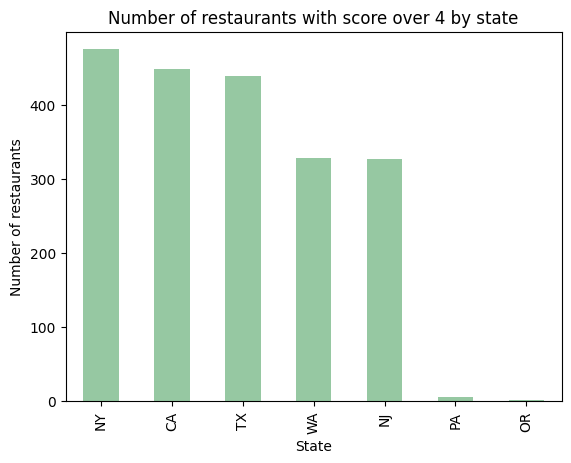

In [80]:
filtered_df = restaurants_data[restaurants_data['Reviews'] > 4]
state_counts = filtered_df['state'].value_counts()
state_counts.plot(kind='bar', color = '#96C8A2')
plt.title('Number of restaurants with score over 4 by state')
plt.xlabel('State')
plt.ylabel('Number of restaurants')
plt.show()

In [81]:
people_data = pd.DataFrame(list(people_collection.find()))
print(people_data.head())

                        _id               name  \
0  6481afe371548ee10c934c20        Lucas Jones   
1  6481afe571548ee10c934c21  Scarlett Thompson   
2  6481afe771548ee10c934c22     James Thompson   
3  6481afe971548ee10c934c23      Joseph Taylor   
4  6481afeb71548ee10c934c24       Noah Jackson   

                                  restaurant_visited  
0  [{'restaurant': 'Guy Fieri's Chophouse', 'scor...  
1  [{'restaurant': 'Blue Water Cafe', 'score': 3.0}]  
2  [{'restaurant': 'Istanbul Grill &Bar', 'score'...  
3  [{'restaurant': 'Craft And Gather', 'score': 5...  
4  [{'restaurant': 'The Cabin Restaurant', 'score...  


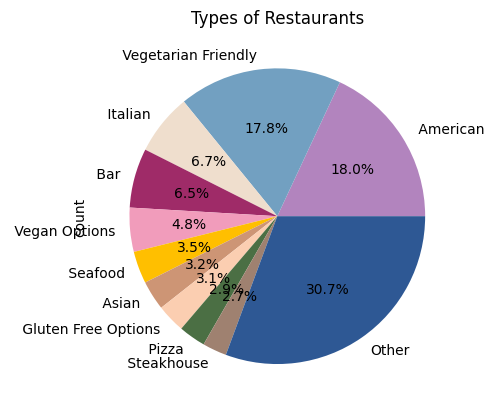

In [82]:
types = restaurants_data['Type'].str.split(',').explode()
type_counts = types.value_counts()
top_10_types = type_counts.head(10)
other_types_count = type_counts[10:].sum()
top_10_types['Other'] = other_types_count

colors = ['#B284BE', '#72A0C1', '#EFDECD', '#9F2B68', '#F19CBB', '#FFBF00', '#CD9575', '#FBCEB1', '#4B6F44', '#9F8170', '#2E5894', '#54626F', '#E97451', '#A3C1AD', '#FFFF99']
top_10_types.plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title('Types of Restaurants')
plt.show()


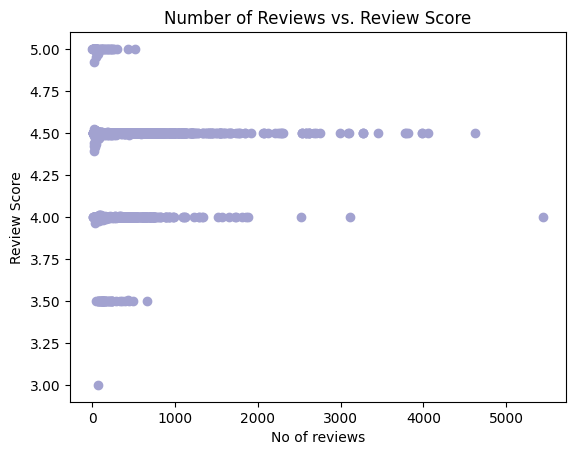

In [83]:
plt.scatter(restaurants_data['No of Reviews'], restaurants_data['Reviews'], color = '#A2A2D0')
plt.title('Number of Reviews vs. Review Score')
plt.xlabel('No of reviews')
plt.ylabel('Review Score')
plt.show()

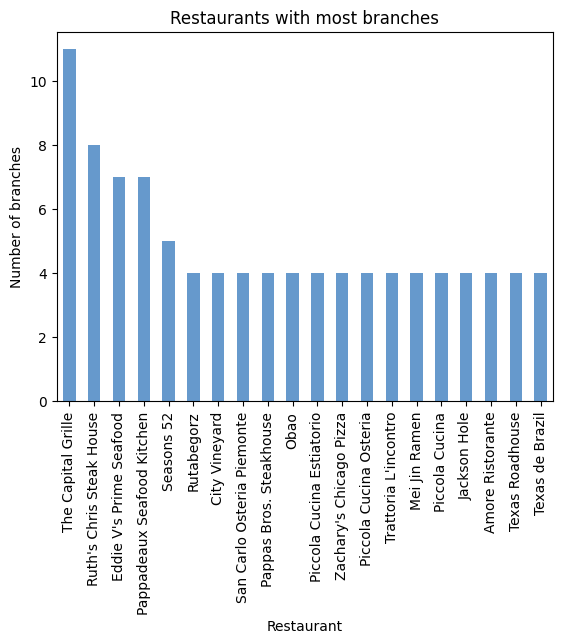

In [84]:
state_counts = filtered_df['Name'].value_counts().head(20)
state_counts.plot(kind='bar', color="#6699CC")
plt.title('Restaurants with most branches')
plt.xlabel('Restaurant')
plt.ylabel('Number of branches')
plt.show()

WordCloud for restaurants that have score gt 4

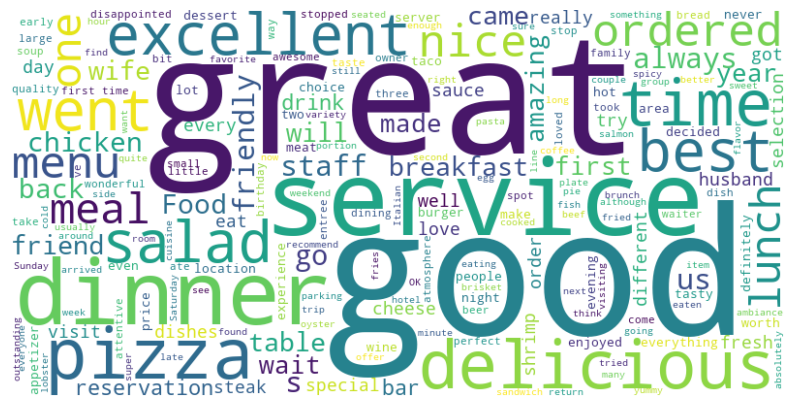

In [85]:
word_data = restaurants_data[restaurants_data['Reviews'] > 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for restaurants that have score lt 4

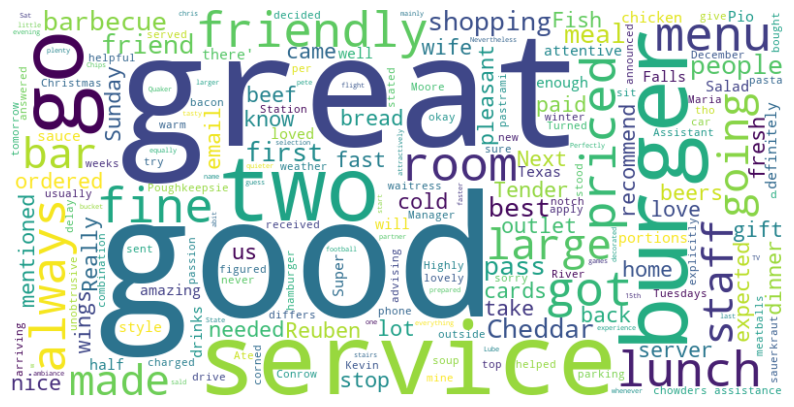

In [86]:
word_data = restaurants_data[restaurants_data['Reviews'] < 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [87]:
from geopy.exc import GeocoderTimedOut

data = restaurants_data[restaurants_data['Reviews'] == 5].copy()

geolocator = Bing(api_key='AhpwrCFQAHjj_6XelmahpGUxECXe1tonsrdoV2zAc9VJETqAj-6ekcmoMaKv5Ri6')

def geocode_with_timeout(location):
    try:
        return geolocator.geocode(location)
    except GeocoderTimedOut:
        return None

data.loc[:, 'address'] = data['Street Address'] + ", " + data['Location']
data.loc[:, 'new_location'] = data['address'].apply(geocode_with_timeout)
data.loc[:, 'Latitude'] = data['new_location'].apply(lambda x: x.latitude if x is not None else np.nan)
data.loc[:, 'Longitude'] = data['new_location'].apply(lambda x: x.longitude if x is not None else np.nan)

print(data.head())



                          _id                  Name         Street Address  \
29   6481afd6781d3373dba6db2b            Tabernilla  7124 Bob Bullock Loop   
135  6481afd6781d3373dba6db95            Ambrogio15       926 Turquoise St   
266  6481afd6781d3373dba6dc18            Very Juice           422 Avenue P   
276  6481afd6781d3373dba6dc22  HiroNori Craft Ramen      2222 Michelson Dr   
280  6481afd6781d3373dba6dc26        Bean's & Lager          3301 36th Ave   

                            Location                                   Type  \
29             Laredo, TX 78041-2080       Spanish, Mediterranean, Wine Bar   
135         San Diego, CA 92109-1186               Italian, Pizza, Wine Bar   
266          Brooklyn, NY 11223-1935                                          
276            Irvine, CA 92612-1332   Japanese, Asian, Vegetarian Friendly   
280  Long Island City, NY 11106-1941              American, Steakhouse, Bar   

     Reviews  No of Reviews  \
29       5.0           39

### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

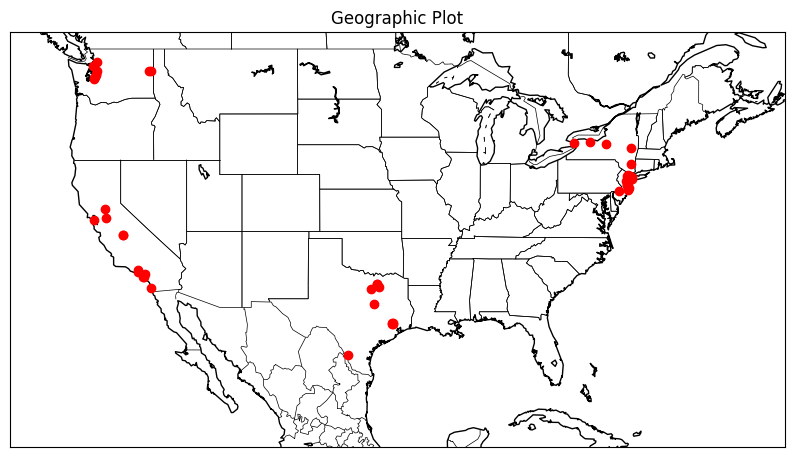

In [88]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

map = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='l')

map.drawcoastlines()
map.drawcountries()
map.drawstates()

x, y = map(data['Longitude'].astype(float), data['Latitude'].astype(float))
map.scatter(x, y, marker='o', color='red', zorder=5)
plt.title('Geographic Plot')
plt.show()


### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

In [90]:
# Create a map centered on the United States
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for index, row in data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map


In [92]:
full_name = "Scarlett Thompson"
state = "ny"
city = "Poughkeepsie"
street = "South Rd Ste C"

url = "http://localhost:8001/restaurant/recommendation/{}/{}/{}/{}".format(
    full_name.replace(" ", "%20"),
    state,
    city.replace(" ", "%20"),
    street.replace(" ", "%20")
)

response = requests.get(url)
new_data = response.json()
Longitude_list = [item['coordinates']['coordinates'][0] if isinstance(item, dict) else np.nan for item in new_data]
Latitude_list = [item['coordinates']['coordinates'][1] if isinstance(item, dict) else np.nan for item in new_data]

new_data = pd.DataFrame(new_data)
new_data['Longitude'] = Longitude_list
new_data['Latitude'] = Latitude_list


In [93]:
location = geolocator.geocode(" ".join([city, ",", state]))
map = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

for index, row in new_data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with available latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map